### Team members

##### Chirag Bhuvaneshwara
* 2571703
* s8chbhuv@stud.uni-saarland.de

##### Priyasha Chatterjee 
* 2572739
* s8prchat@stud.uni-saarland.de

In [141]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
import scipy.ndimage.filters as fi


In [89]:
colaImage = Image.open("noisycoke.jpg")
colaImageMat = np.array(colaImage)
colaImageMat.shape

(640, 480)

# 1.1 Mirroring the image

In [91]:
def imgmirror(img, w):
    
    oldShape = img.shape
    newShape = (oldShape[0]+2*w, oldShape[1]+2*w)
    
    newImg = np.zeros(newShape)
    
    # Filling in the new image with only the entries from the old image
    for i in range(oldShape[0]):
        for j in range(oldShape[1]):
            newImg[i+w, j+w] += img[i,j]
    
    # Mirroring on the left, corners won't be reflected
    for i in range(w, newShape[0]-w):
        for j in range(w):
            newImg[i, w-j-1] += img[i-w, j]
    
    # Mirroring on the top, top left corner will be reflected
    for i in range(w):
        for j in range(newShape[1]):
            newImg[w-i-1,j] += newImg[i+w,j]
            
    # Mirroring on the right, top right corner will be reflected
    for i in range(newShape[0]):
        for j in range(newShape[1]-w, newShape[1]):
            newImg[i, j] += newImg[i, j-w]
    # Flipping horizontally        
    newImg[:newShape[0], newShape[1]-w:newShape[1]] = np.fliplr(newImg[:newShape[0], newShape[1]-w:newShape[1]] )

    
    # Mirroring on the bottom, bottom left and right corners will be reflected
    for i in range(newShape[0]-w, newShape[0]):
        for j in range(newShape[1]):
            newImg[i,j] += newImg[i-w, j]
    # Flipping Vertically
    newImg[newShape[0]-w:newShape[0], :newShape[1]] = np.flipud(newImg[newShape[0]-w:newShape[0], :newShape[1]])
    
    return newImg 

In [93]:
imgmirror(colaImageMat,2).shape

(644, 484)

In [90]:
r = np.arange(1,37).reshape(6,6)
r

array([[ 1,  2,  3,  4,  5,  6],
       [ 7,  8,  9, 10, 11, 12],
       [13, 14, 15, 16, 17, 18],
       [19, 20, 21, 22, 23, 24],
       [25, 26, 27, 28, 29, 30],
       [31, 32, 33, 34, 35, 36]])

In [218]:
imgmirror(r,2)

array([[ 8.,  7.,  7.,  8.,  9., 10., 11., 12., 12., 11.],
       [ 2.,  1.,  1.,  2.,  3.,  4.,  5.,  6.,  6.,  5.],
       [ 2.,  1.,  1.,  2.,  3.,  4.,  5.,  6.,  6.,  5.],
       [ 8.,  7.,  7.,  8.,  9., 10., 11., 12., 12., 11.],
       [14., 13., 13., 14., 15., 16., 17., 18., 18., 17.],
       [20., 19., 19., 20., 21., 22., 23., 24., 24., 23.],
       [26., 25., 25., 26., 27., 28., 29., 30., 30., 29.],
       [32., 31., 31., 32., 33., 34., 35., 36., 36., 35.],
       [32., 31., 31., 32., 33., 34., 35., 36., 36., 35.],
       [26., 25., 25., 26., 27., 28., 29., 30., 30., 29.]])

# 1.2 Gaussian Filtering

In [277]:
def gaussfilter(img, kernel, verbose = False):
    
    time1 = time.time()
    w = kernel.shape[0]
    imgMirror = imgmirror(img, w)
    
    a = int(w/2)
    
    newImg = np.zeros(img.shape)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            
            for k in range(w):
                for l in range(w):
                    newImg[i,j] += imgMirror[i+k-a, j+l-a] * kernel[k,l]
    
    time2 = time.time()
        
    if verbose == True:
        print('"gaussfilter" Function took {:.3f} ms'.format((time2-time1)*1000.0))
    
    return newImg
    

# 1.3 Denoising Coke

In [278]:
def gkern2(kernlen=5, nsig=3):
    """Returns a 2D Gaussian kernel array."""

    # create nxn zeros
    inp = np.zeros((kernlen, kernlen))
    # set element at the middle to one, a dirac delta
    inp[kernlen//2, kernlen//2] = 1
    # gaussian-smooth the dirac, resulting in a gaussian filter mask
    return fi.gaussian_filter(inp, nsig)

In [279]:
gkern2( nsig=5)

array([[0.04000038, 0.03999926, 0.04000168, 0.03999926, 0.04000038],
       [0.03999926, 0.03999813, 0.04000055, 0.03999813, 0.03999926],
       [0.04000168, 0.04000055, 0.04000297, 0.04000055, 0.04000168],
       [0.03999926, 0.03999813, 0.04000055, 0.03999813, 0.03999926],
       [0.04000038, 0.03999926, 0.04000168, 0.03999926, 0.04000038]])

In [280]:
smoothedImage = gaussfilter(colaImageMat, gkern2(kernlen=5, nsig=3), True)

"gaussfilter" Function took 10945.753 ms


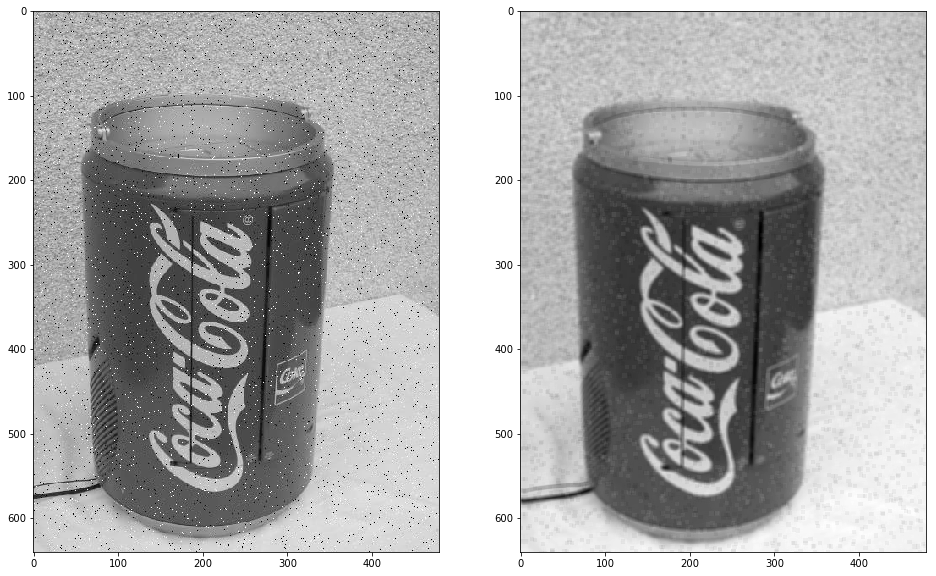

In [281]:
images= [colaImageMat, smoothedImage]

fig=plt.figure(figsize=(16, 16))

columns = 2
rows = 1

for i in range(1, 3):

    fig.add_subplot(rows, columns, i)
    plt.imshow(images[i-1].astype(np.uint8), cmap = "gray")
# plt.imsave(str(i)+".png", images[i-1].astype(np.uint8))
plt.show()

# 1.4 Using Separability property

In [312]:
def gaussfilter(img, kernel, verbose = True):
    
    time1 = time.time()
    w = kernel.shape[0]
    imgMirror = imgmirror(img, w)
    
    a = int(w/2)
    
    newImg = np.zeros(img.shape)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            
            for k in range(w):
                newImg[i,j] += imgMirror[i, j+k-a]  * kernel[k]

    newImgMirror = imgmirror(newImg, w)   
    newImg = np.zeros(img.shape)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            
            for l in range(w):
                newImg[i,j] += newImgMirror[i+l-a, j] * kernel[l]
    
    time2 = time.time()
        
    if verbose == True:
        print('"gaussfilter" Function took {:.3f} ms'.format((time2-time1)*1000.0))
    
    return newImg

In [313]:
def gkern1(kernlen=5, nsig=1):
    """Returns a 2D Gaussian kernel array."""

    # create n zeros
    inp = np.zeros((kernlen))
    # set element at the middle to one, a dirac delta
    inp[kernlen//2] = 1
    # gaussian-smooth the dirac, resulting in a gaussian filter mask
    return fi.gaussian_filter1d(inp, nsig)

In [314]:
smoothedImage2 = gaussfilter(colaImageMat, gkern1(nsig = 3))

"gaussfilter" Function took 4114.030 ms


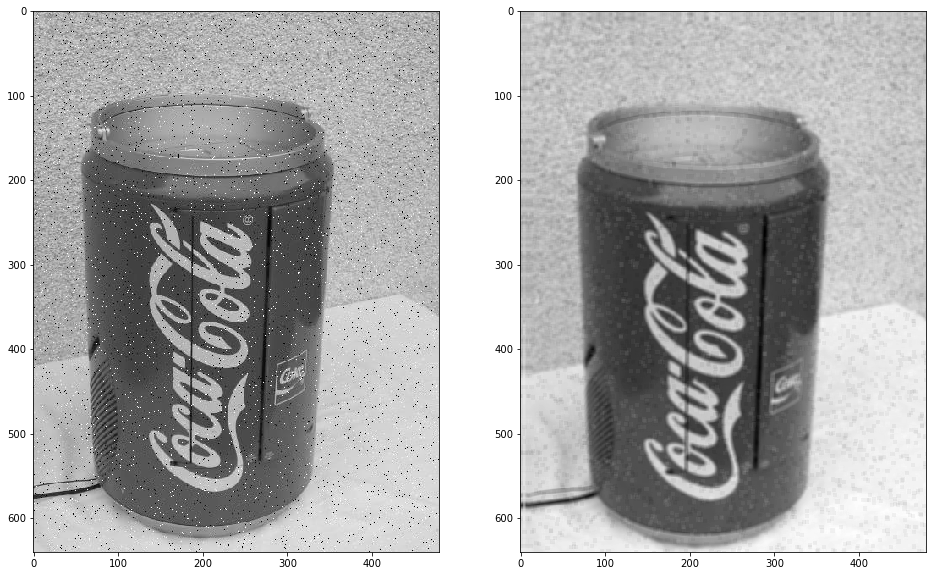

In [315]:
images= [colaImageMat, smoothedImage2]

fig=plt.figure(figsize=(16, 16))

columns = 2
rows = 1

for i in range(1, 3):

    fig.add_subplot(rows, columns, i)
    plt.imshow(images[i-1].astype(np.uint8), cmap = "gray")
# plt.imsave(str(i)+".png", images[i-1].astype(np.uint8))
plt.show()

# 2. Fourier Transform properties

In [320]:
from IPython.display import display, Image

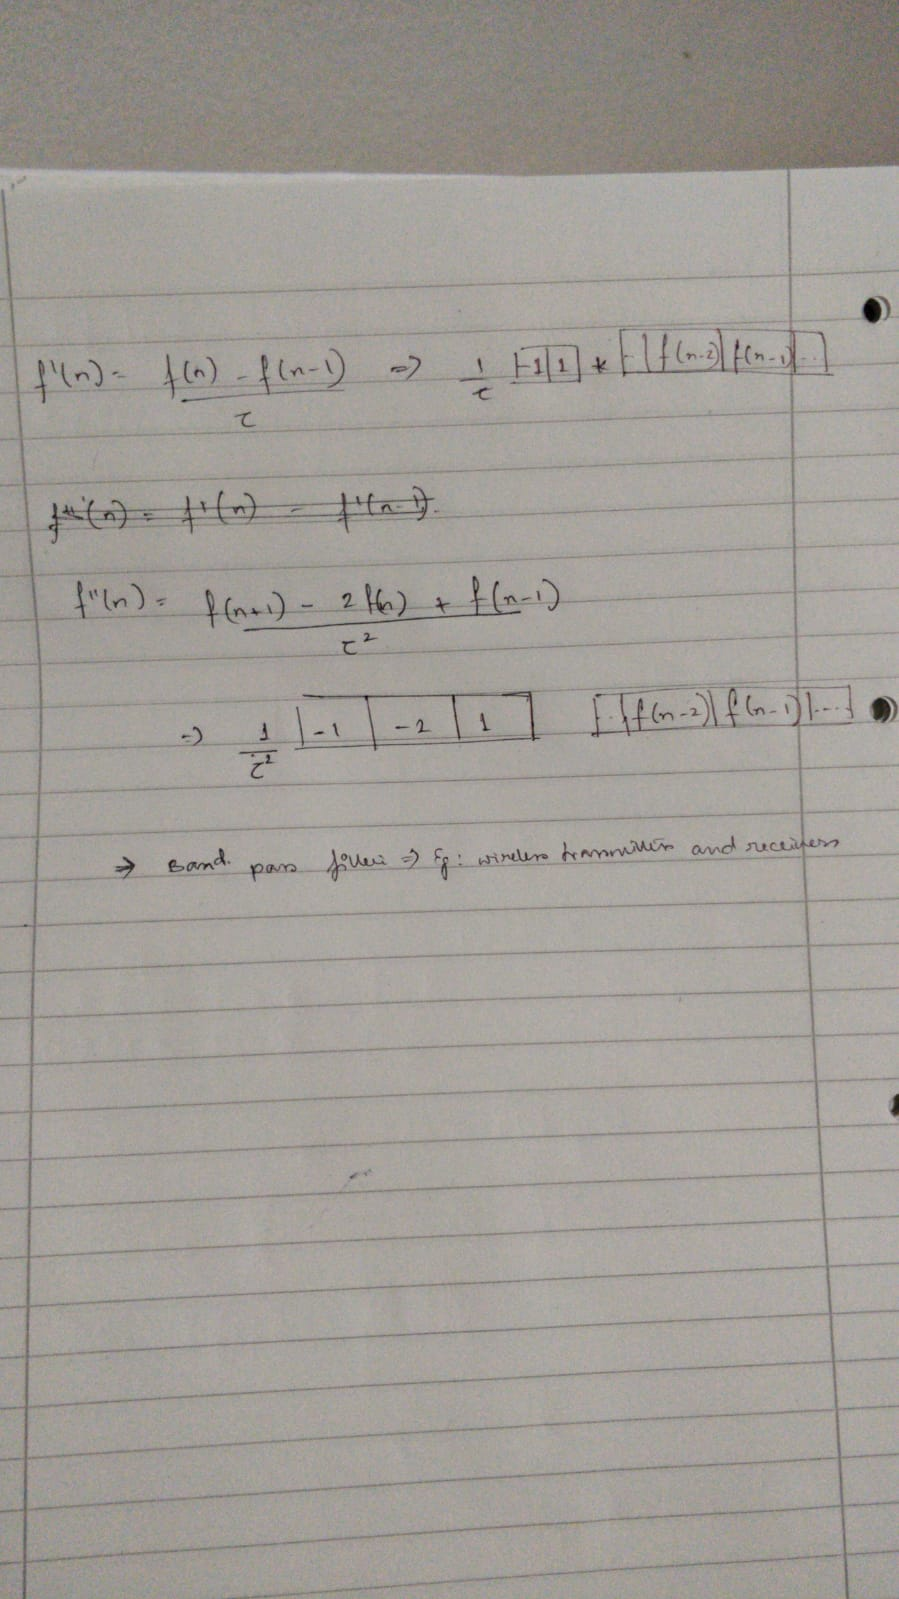

In [321]:
display(Image(filename='HandwrittenSolutions/WhatsApp Image 2019-05-11 at 11.57.21 PM.jpeg'))